In [1]:
import pandas as pd
import nltk
import gensim
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

In [2]:
df =pd.read_csv("./content/archive/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.csv")

In [3]:
df.head(5)

,flags,utterance,category,intent
0,BILC,"I don't have an online account, what do I have...",ACCOUNT,create_account
1,BILQZ,can you tell me if i can regisger two accounts...,ACCOUNT,create_account
2,BPLC,"I have no online account, open one, please",ACCOUNT,create_account
3,BIPLD,"could you ask an agent how to open an account,...",ACCOUNT,create_account
4,BLQC,"i want an online account, create one",ACCOUNT,create_account


## Basic Processing

In [4]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
english_stopwords = stopwords.words('english')
english_stopwords.extend(['u','could','would'])
porter = PorterStemmer()
def preprocess(text):
    text = text.lower()
    token = word_tokenize(text)
    token = [porter.stem(word) for word in token if (word not in english_stopwords) and word.isalpha()]
    return token
df['words'] = df['utterance'].apply(lambda x: preprocess(x))
print(df['words'].head())
print(df['words'].describe())

0                             [onlin, account, regist]
1    [tell, regisg, two, account, singl, email, add...
2                   [onlin, account, open, one, pleas]
3                   [ask, agent, open, account, pleas]
4                   [want, onlin, account, creat, one]
Name: words, dtype: object
count           21534
unique           9636
top       [see, bill]
freq               31
Name: words, dtype: object


## Latent Dirichlet Allocation (LDA)

In [5]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim import models

# generate dictionary (bag of words)
docs_dictionary = Dictionary(list(df['words']))
# transfer each document into (word_index, frequency)
docs_corpus = [docs_dictionary.doc2bow(doc) for doc in list(df['words'])]
# tfidf
tfidf = models.TfidfModel(docs_corpus,normalize=False)
docs_corpus_tfidf = tfidf[docs_corpus]

In [6]:
#Train the model
lda_model = LdaModel(corpus=docs_corpus_tfidf, 
               id2word=docs_dictionary,
               num_topics=11,
               chunksize=2000,
               passes=10,
               random_state=8307)

In [7]:
lda_model.print_topics(num_topics=11,num_words=10)

[(0,
  '0.174*"like" + 0.125*"complaint" + 0.118*"servic" + 0.073*"consum" + 0.069*"happi" + 0.066*"id" + 0.065*"lodg" + 0.062*"file" + 0.049*"submit" + 0.047*"mail"'),
 (1,
  '0.106*"get" + 0.101*"reimburs" + 0.099*"refund" + 0.094*"obtain" + 0.092*"request" + 0.088*"postpon" + 0.083*"cancel" + 0.056*"na" + 0.056*"wan" + 0.055*"event"'),
 (2,
  '0.193*"ask" + 0.190*"agent" + 0.115*"check" + 0.081*"view" + 0.079*"invoic" + 0.079*"bill" + 0.072*"pleas" + 0.048*"receiv" + 0.016*"comment" + 0.016*"opinion"'),
 (3,
  '0.234*"statu" + 0.191*"fuck" + 0.155*"purchas" + 0.142*"pleas" + 0.046*"product" + 0.045*"bought" + 0.045*"item" + 0.024*"order" + 0.023*"made" + 0.023*"mistak"'),
 (4,
  '0.145*"tell" + 0.141*"want" + 0.130*"know" + 0.125*"track" + 0.061*"packag" + 0.059*"shipment" + 0.046*"newslett" + 0.042*"download" + 0.041*"someth" + 0.021*"subscrib"'),
 (5,
  '0.098*"payment" + 0.085*"pay" + 0.072*"issu" + 0.072*"problem" + 0.066*"tri" + 0.065*"error" + 0.059*"notifi" + 0.058*"report" +

In [8]:
def get_lda_topics(model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10)
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)

In [9]:
get_lda_topics(lda_model, 11)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11
0,like,get,ask,statu,tell,payment,help,make,see,account,refund
1,complaint,reimburs,agent,fuck,want,pay,need,inform,deliveri,email,ship
2,servic,refund,check,purchas,know,issu,one,chang,custom,profil,reimburs
3,consum,obtain,view,pleas,track,problem,onlin,back,option,user,show
4,happi,request,invoic,product,packag,tri,want,modifi,contact,creat,polici
5,id,postpon,bill,bought,shipment,error,account,want,servic,regist,address
6,lodg,cancel,pleas,item,newslett,notifi,dont,guarante,client,address,money
7,file,na,receiv,order,download,report,open,ca,support,singl,set
8,submit,wan,comment,made,someth,order,place,lost,human,sever,find
9,mail,event,opinion,mistak,subscrib,card,ahv,password,talk,tell,method


In [10]:
#Coherence Score
from gensim.models import CoherenceModel
coherence_lda = CoherenceModel(model=lda_model, 
             texts=list(df['words']), 
             coherence='c_v',
             dictionary=docs_dictionary).get_coherence()

print('Coherence Score: ', coherence_lda)

Coherence Score:  0.46602854069966654


In [11]:
#Save the model
lda_model.save("./lda_model")

/var/folders/37/pbn_lksn43z6gmhc9plfcrlh0000gn/T/ipykernel_8201/810460258.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df2.loc[df2.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/37/pbn_lksn43z6gmhc9plfcrlh0000gn/T/ipykernel_8201/810460258.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df2.loc[df2.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/37/pbn_lksn43z6gmhc9plfcrlh0000gn/T/ipykernel_8201/810460258.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df2.loc[df2.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/37/pbn_lksn43z6gmhc9plfcrlh0000gn/T/ipykernel_8201/810460258.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df2.loc[df2.topic_id==i, 'word'], rotation=30, horizontalalig

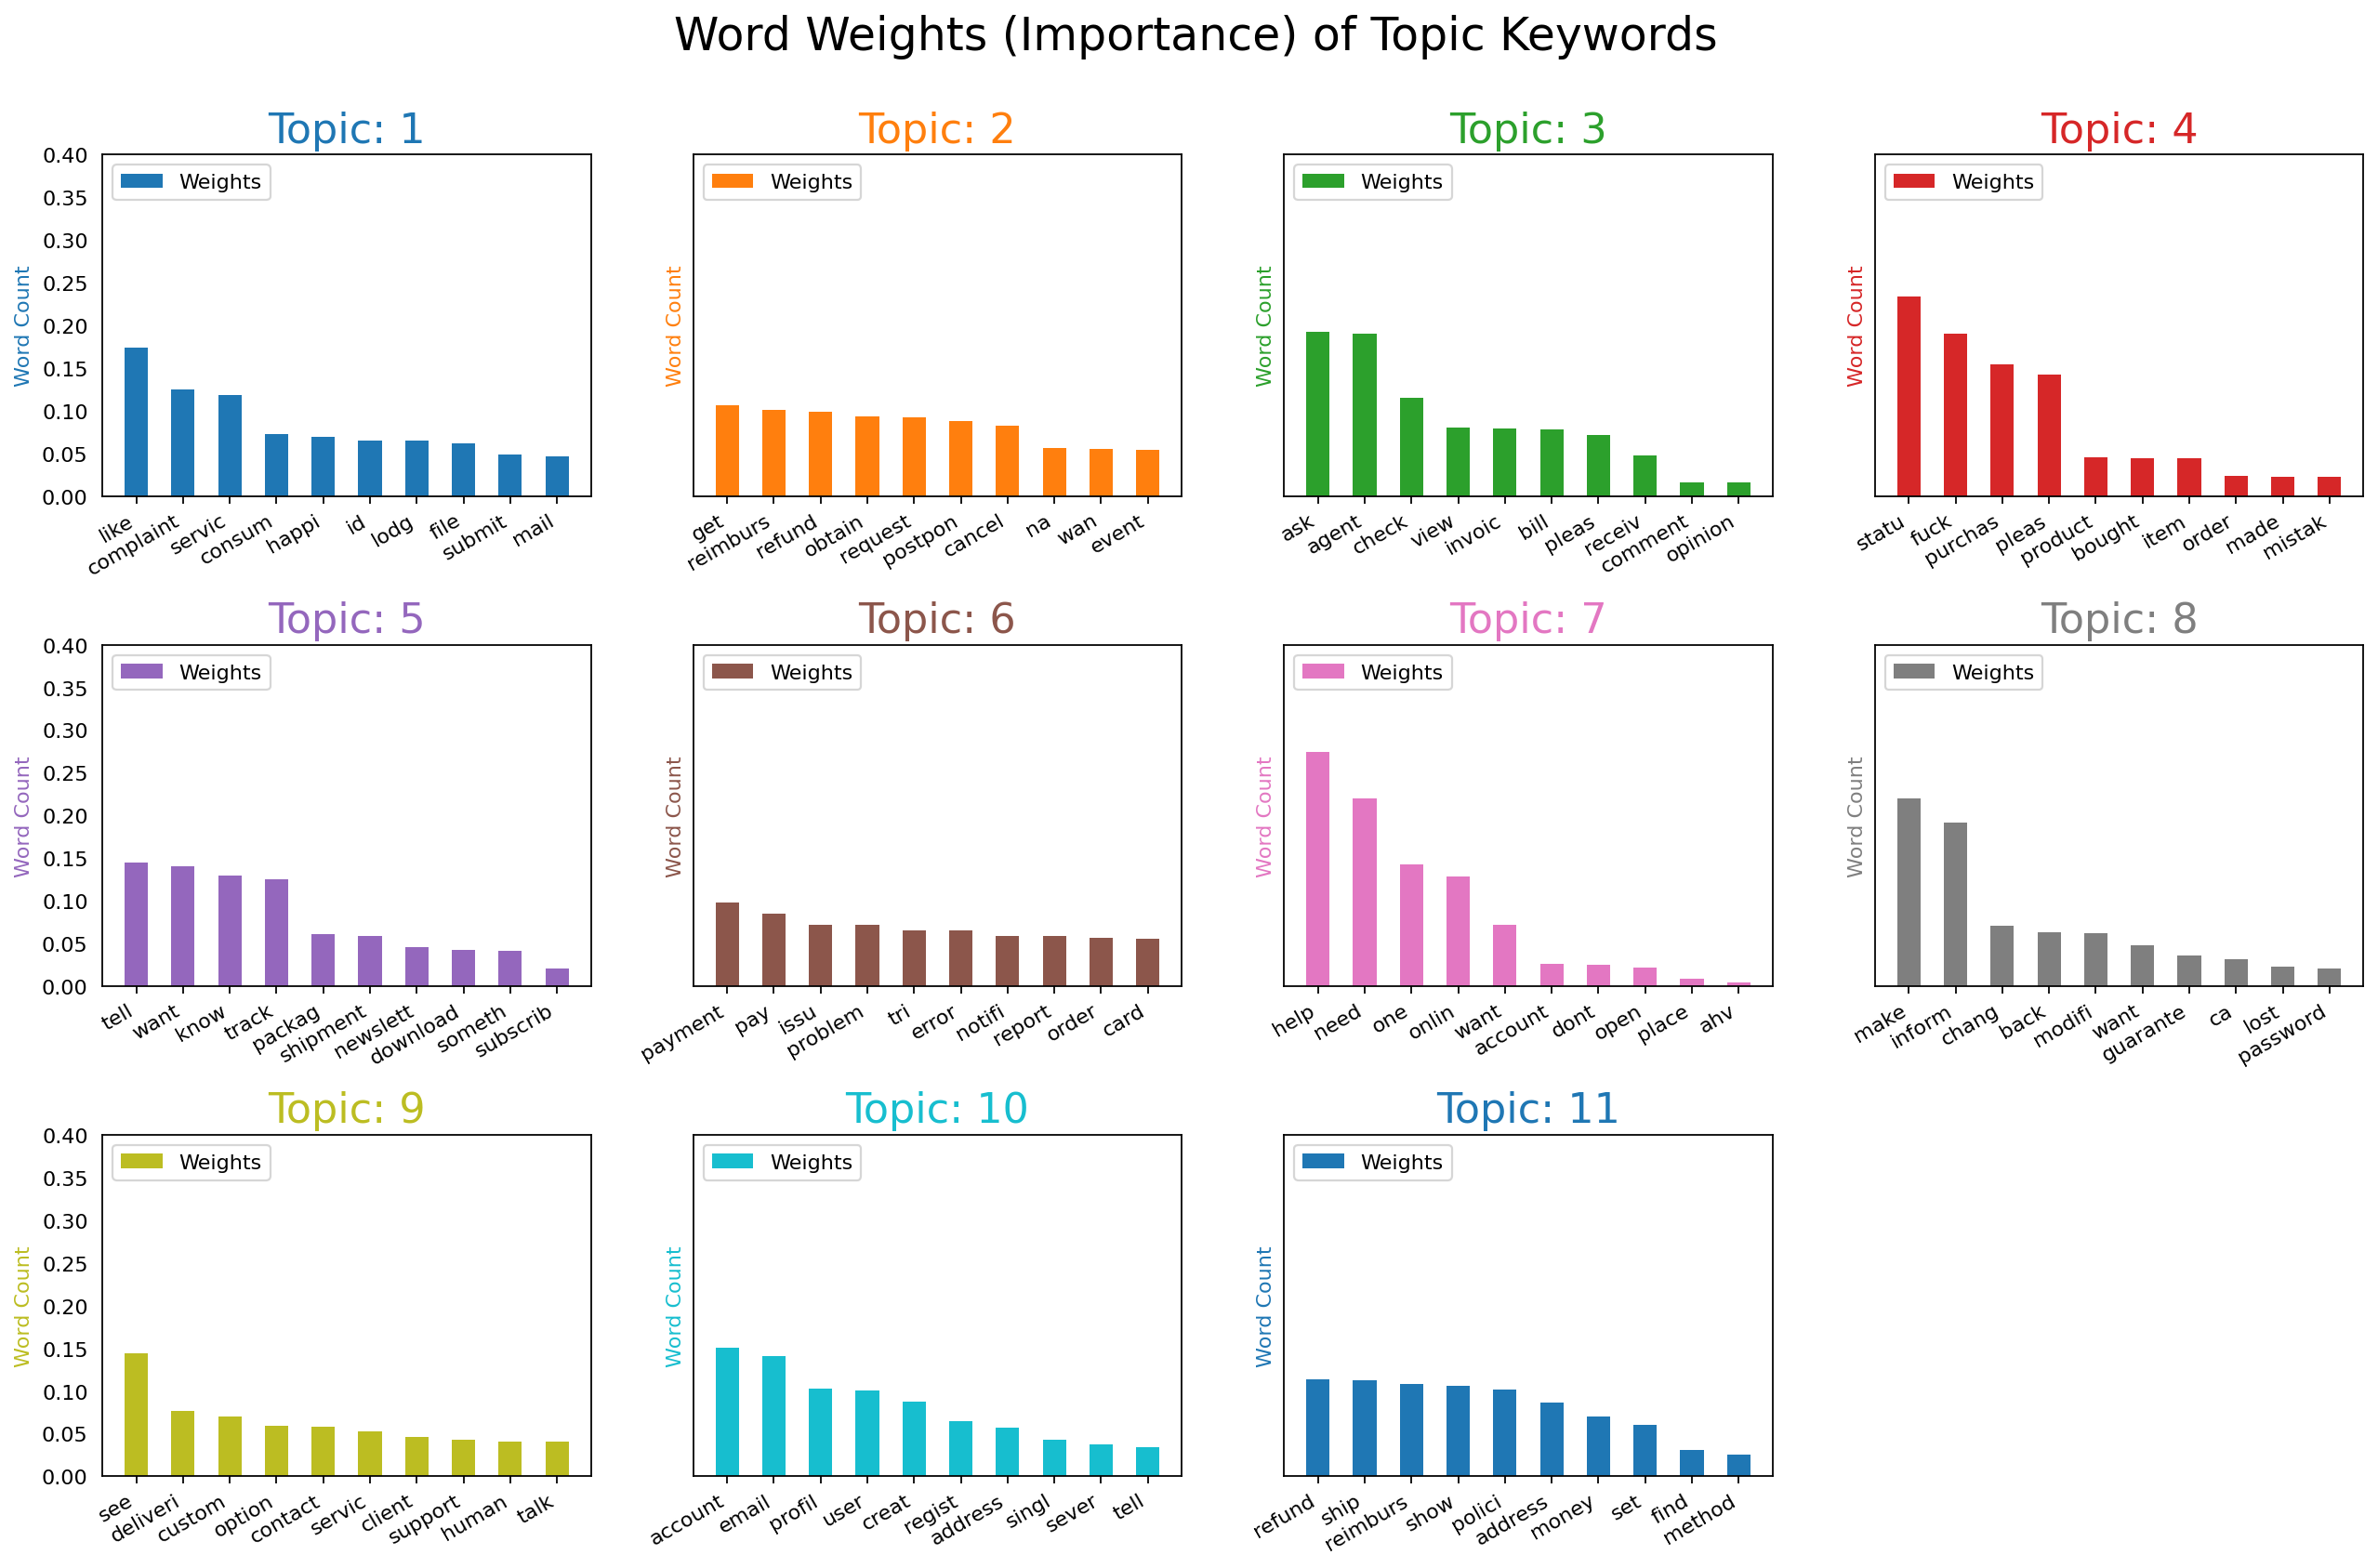

In [12]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter
topics = lda_model.show_topics(num_topics=11, formatted=False)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight])

df2 = pd.DataFrame(out, columns=['word', 'topic_id', 'importance'])        

# Plot Weights of Topic Keywords
fig, axes = plt.subplots(3, 4, figsize=(16,10), sharey=True, dpi=160)
fig.delaxes(axes[2,3])

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cols.append('#1f77b4')

for i, ax in enumerate(axes.flatten()):
    if i < len(topics):
        ax.bar(x='word', height="importance", data=df2.loc[df2.topic_id==i, :], color=cols[i], width=0.5, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_ylim(0, 0.4)
        ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=20)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df2.loc[df2.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left');

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Weights (Importance) of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

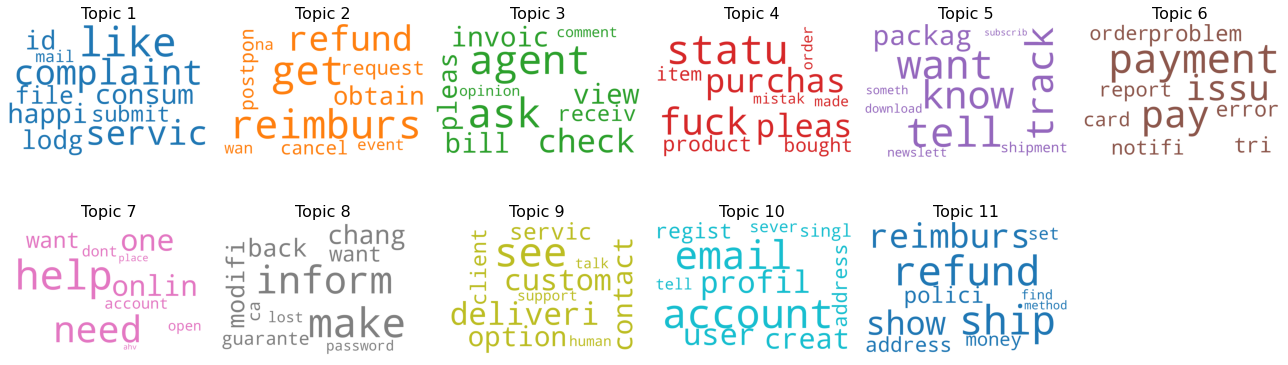

In [13]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols.append('#1f77b4')

# Plot WordClound of Topic Keywords
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=1500,
                  height=1000,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i]
                  #,prefer_horizontal=1.0
                 )

topics = lda_model.show_topics(num_topics=11,formatted=False)

fig, axes = plt.subplots(2, 6, figsize=(18,6), sharex=True, sharey=True)
fig.delaxes(axes[1,5])

for i, ax in enumerate(axes.flatten()):
    if i < len(topics):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title("Topic " + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [14]:
import pyLDAvis
from pyLDAvis import gensim_models

/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [15]:
# illustration of usage
pyLDAvis.enable_notebook()
vis = gensim_models.prepare(lda_model, docs_corpus, 
                              docs_dictionary)
vis

/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.015980 -0.134597       1        1  17.834032
2      0.048204 -0.302321       2        1  11.754396
7     -0.159749  0.090936       3        1  11.571909
8     -0.179065  0.074671       4        1  11.246357
9      0.023235  0.056657       5        1   9.252351
6     -0.198591  0.123019       6        1   8.854332
1      0.320895  0.147710       7        1   7.436851
4     -0.158653  0.111171       8        1   7.089137
0     -0.070751 -0.017777       9        1   5.462012
3      0.047152 -0.315122      10        1   5.262520
10     0.311342  0.165653      11        1   4.236103, topic_info=          Term         Freq        Total Category  logprob  loglift
332       make  2579.000000  2579.000000  Default  30.0000  30.0000
16        help  2975.000000  2975.000000  Default  29.0000  29.0000
13         ask  2289.000000  2289.000000  Default  28.0000  28.0000
330     inform  2249.000000  2249.000000  Default  27.0000  27.0000
12       agent  2262.000000  2262.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1594       bck     5.704920     5.998957  Topic11  -6.6213   3.1113
1578    refund   486.714488  1232.434086  Topic11  -2.1750   2.2325
3      address   369.722540   900.485704  Topic11  -2.4499   2.2713
1576  reimburs   464.449911  1223.876672  Topic11  -2.2218   2.1926
15        want     7.735383  2573.754671  Topic11  -6.3168  -2.6458

[390 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1314      1  1.007789   accept
0         5  0.855316  account
0         6  0.144680  account
182       5  1.000178      acn
513       7  0.870600   acncel
...     ...       ...      ...
1342      8  1.003483       wo
897       2  0.999227    write
319       3  0.988784       ym
701       4  0.991430     your
1716     10  1.015205      yoy

[369 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 8, 9, 10, 7, 2, 5, 1, 4, 11])

### Optimal Number of Topics

In [16]:
from gensim.models import CoherenceModel

def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                        id2word=dictionary,
                                        num_topics=k, 
                                        random_state=8307,
                                        chunksize=2000,
                                        passes=10)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=list(df['words']), dictionary=docs_dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [17]:
import numpy as np

# Topics range
min_topics = 3
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
model_results = {
                 'Topics': [],
                 'Coherence': []
                }

for k in topics_range:
                    # get the coherence score for the given parameters
    cv = compute_coherence_values(corpus=docs_corpus_tfidf, dictionary=docs_dictionary, 
                                                  k=k)
    # Save the model results
    model_results['Topics'].append(k)
    model_results['Coherence'].append(cv)
                    
                   

In [18]:
pd.DataFrame(model_results)

,Topics,Coherence
0,3,0.373955
1,4,0.393510
2,5,0.407638
3,6,0.424846
4,7,0.418281
5,8,0.453644
6,9,0.468575
7,10,0.462991


### Model Inference

In [19]:
doc_sample = 'how can i write an opinion for a service?'
preprocess(doc_sample)
doc_sample = docs_dictionary.doc2bow(preprocess(doc_sample))
list(lda_model[tfidf[doc_sample]])

[(0, 0.17765896), (2, 0.77848786)]

## Non-negative Matrix Factorization (NMF)

In [20]:
sentences = [' '.join(text) for text in list(df['words'])]

In [21]:
vectorizer = CountVectorizer(analyzer='word', max_features=5000);
x_counts = vectorizer.fit_transform(sentences)

In [22]:
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

In [23]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [24]:
#number of topics
num_topics=11
#obtain a NMF model.
model = NMF(n_components=num_topics, init='nndsvd');
#fit the model
model.fit(xtfidf_norm)

NMF(init='nndsvd', n_components=11)

In [25]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict)

In [26]:
get_nmf_topics(model, 10)

/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11
0,payment,invoic,account,agent,servic,order,help,refund,bill,check,want
1,problem,see,one,ask,custom,purchas,human,reimburs,see,deliveri,know
2,issu,tell,user,pleas,client,chang,need,cancel,tell,option,profil
3,pay,view,onlin,fuck,complaint,modifi,talk,obtain,download,packag,track
4,make,download,creat,payment,inform,tell,speak,request,view,tell,delet
5,notifi,get,open,profil,contact,track,contact,get,request,shipment,inform
6,report,receiv,regist,human,support,someth,someon,postpon,lost,ticket,remov
7,inform,request,got,track,email,product,person,show,obtain,track,close
8,tri,obtain,hack,solv,mail,item,understand,event,receiv,statu,use
9,card,lost,email,password,address,pay,ca,game,get,polici,newslett


In [27]:
feature_names = vectorizer.get_feature_names()
n_top_words=10
words = []
for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    dict_from_list = dict(zip(top_features, weights))
    words.append(dict_from_list)

/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


/var/folders/37/pbn_lksn43z6gmhc9plfcrlh0000gn/T/ipykernel_8201/3345589949.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df2.loc[df2.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/37/pbn_lksn43z6gmhc9plfcrlh0000gn/T/ipykernel_8201/3345589949.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df2.loc[df2.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/37/pbn_lksn43z6gmhc9plfcrlh0000gn/T/ipykernel_8201/3345589949.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df2.loc[df2.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/37/pbn_lksn43z6gmhc9plfcrlh0000gn/T/ipykernel_8201/3345589949.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df2.loc[df2.topic_id==i, 'word'], rotation=30, horizontal

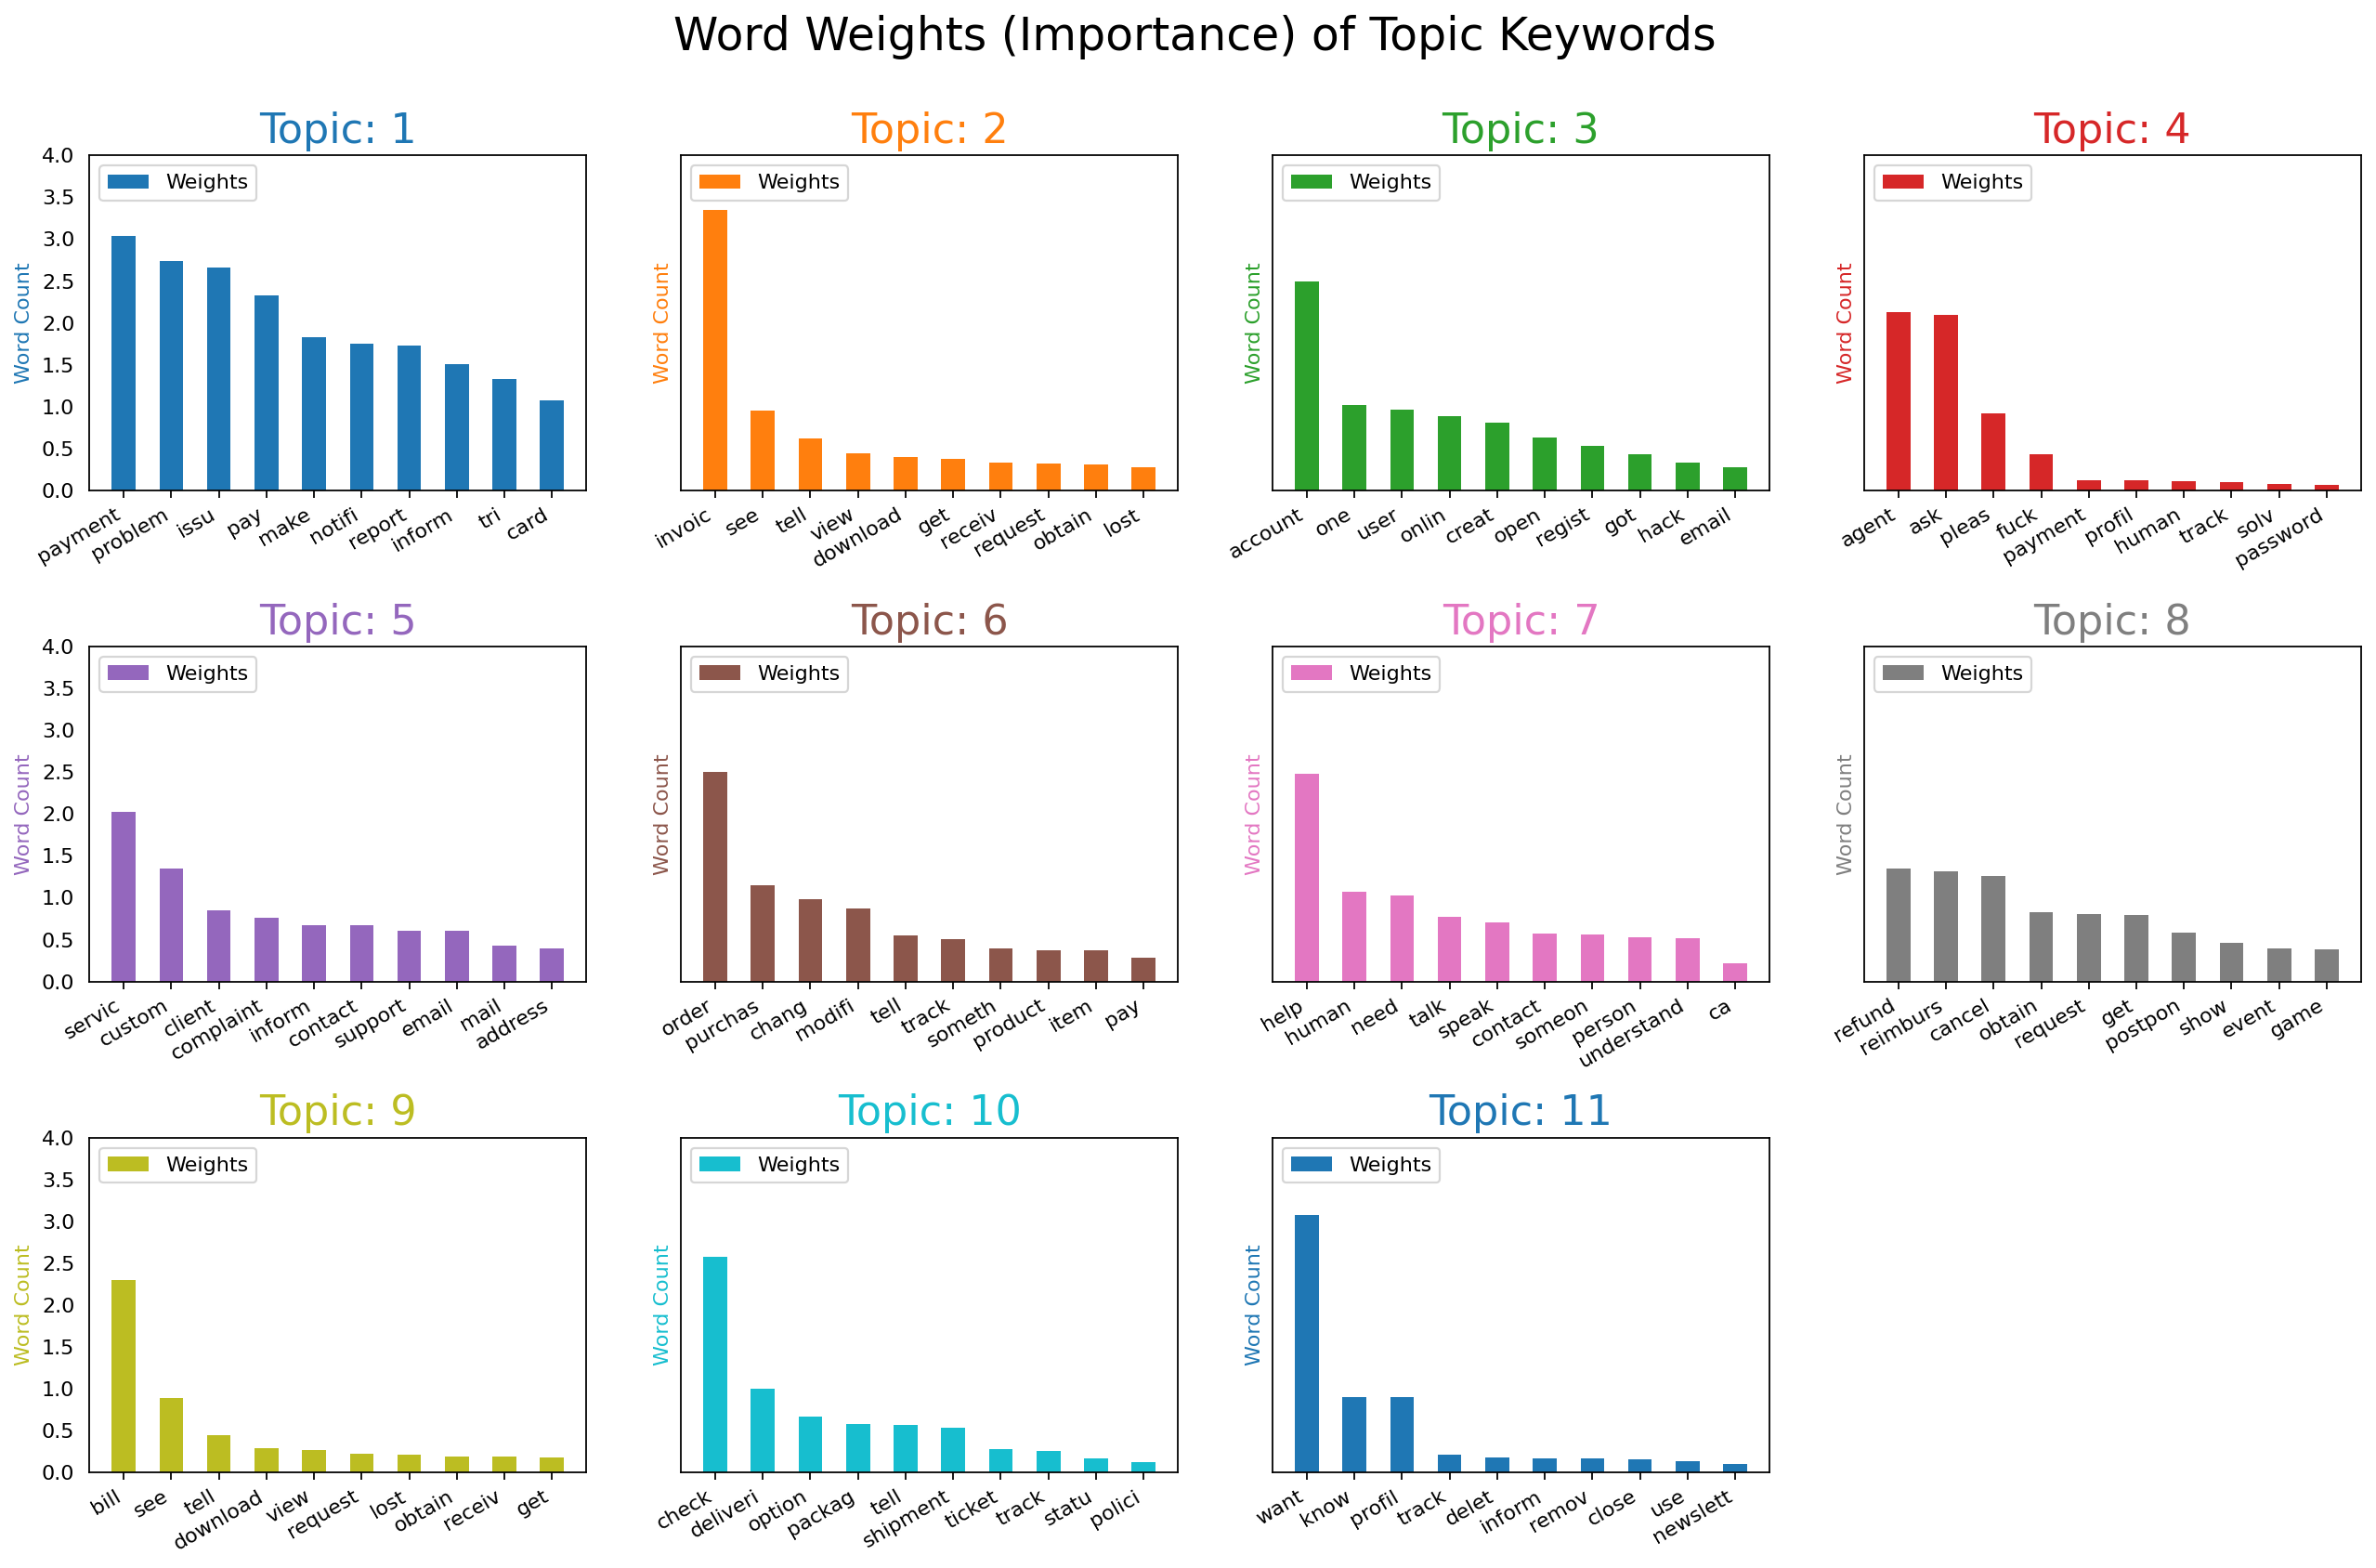

In [28]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter
topics = lda_model.show_topics(num_topics=11, formatted=False)

out = []
for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    for t in range(len(top_features)):
        out.append([top_features[t], topic_idx , weights[t]])

df2 = pd.DataFrame(out, columns=['word', 'topic_id', 'importance'])        

# Plot Weights of Topic Keywords
fig, axes = plt.subplots(3, 4, figsize=(16,10), sharey=True, dpi=160)
fig.delaxes(axes[2,3])

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cols.append('#1f77b4')

for i, ax in enumerate(axes.flatten()):
    if i < len(topics):
        ax.bar(x='word', height="importance", data=df2.loc[df2.topic_id==i, :], color=cols[i], width=0.5, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_ylim(0, 4)
        ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=20)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df2.loc[df2.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left');

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Weights (Importance) of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is depre

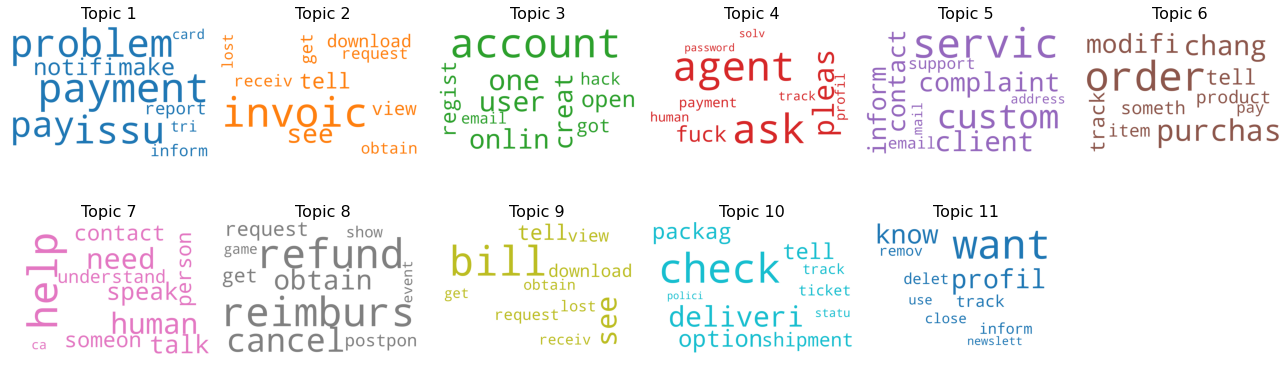

In [29]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols.append('#1f77b4')

# Plot WordCloud of Topic Keywords
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=1500,
                  height=1000,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i]
                  )

fig, axes = plt.subplots(2, 6, figsize=(18,6), sharex=True, sharey=True)
fig.delaxes(axes[1,5])

for i, ax in enumerate(axes.flatten()):
    #print(i)
    if i < len(words):
        fig.add_subplot(ax)
        topic_words = words[i]
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title("Topic " + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [30]:
#Suggested Topics
dict_topic = {1:"PAYMENT", 2:"INVOICES", 3:"ACCOUNT", 4:"CANCELLATION_FEE", 5:"FEEDBACK", 6:"ORDER", 7:"CONTACT", 8:"REFUNDS", 9:"SHIPPING", 10:"DELIVERY", 11:"NEWSLETTER"}

### Model Inference

In [31]:
doc_sample = 'how can i write an opinion for a service?'
preprocess(doc_sample)
joinedtogether = " ".join(preprocess(doc_sample))
joinedtogether
counts = vectorizer.transform([joinedtogether])
sample_tfidf = transformer.transform(counts)
sample_tfidf_norm = normalize(sample_tfidf, norm='l1', axis=1)
nmf_features = model.transform(sample_tfidf_norm)

In [32]:
result_nmf = pd.DataFrame(nmf_features).idxmax(axis=1)
print("Topic " + str(result_nmf[0]))

Topic 4
